<a href="https://colab.research.google.com/github/RajorshiPaul/Asset-Allocation-RL/blob/main/AssetAllocPG_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Clone the rl-book repository
!git clone https://github.com/TikhonJelvis/rl-book.git

# Change the working directory to the rl-book directory
%cd rl-book

# Move to the branch with proper installation requirements
!git checkout notebook
!pip install -r notebooks/notebook-requirements.txt
!pip install -e .

Cloning into 'rl-book'...
remote: Enumerating objects: 7174, done.
remote: Counting objects: 100% (901/901), done.
remote: Compressing objects: 100% (303/303), done.
remote: Total 7174 (delta 564), reused 805 (delta 534), pack-reused 6273
Receiving objects: 100% (7174/7174), 16.51 MiB | 35.21 MiB/s, done.
Resolving deltas: 100% (4316/4316), done.
/content/rl-book
Branch 'notebook' set up to track remote branch 'notebook' from 'origin'.
Switched to a new branch 'notebook'
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 KB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.4/28.4 MB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 769.2/769.2 KB 36.3 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_exte

In [ ]:
from dataclasses import dataclass
from typing import Sequence, Callable, Tuple, Iterator, List
from rl.distribution import Distribution, SampledDistribution, Gaussian
from rl.markov_decision_process import MarkovDecisionProcess, \
    NonTerminal, State, Terminal
from rl.function_approx import AdamGradient, FunctionApprox, DNNSpec, \
    DNNApprox
from rl.approximate_dynamic_programming import QValueFunctionApprox
from rl.approximate_dynamic_programming import ValueFunctionApprox
from rl.policy_gradient import reinforce_gaussian, actor_critic_gaussian, \
    actor_critic_advantage_gaussian, actor_critic_td_error_gaussian
from rl.gen_utils.plot_funcs import plot_list_of_curves
import itertools
import numpy as np

In [ ]:
AssetAllocState = Tuple[int, float]


@dataclass(frozen=True)
class AssetAllocPG:
    risky_return_distributions: Sequence[Distribution[float]]
    riskless_returns: Sequence[float]
    utility_func: Callable[[float], float]
    policy_feature_funcs: Sequence[Callable[[AssetAllocState], float]]
    policy_mean_dnn_spec: DNNSpec
    policy_stdev: float
    initial_wealth_distribution: Distribution[float]

    def time_steps(self) -> int:
        return len(self.risky_return_distributions)

    def get_mdp(self) -> MarkovDecisionProcess[AssetAllocState, float]:
        """
        State is (Wealth W_t, Time t), Action is investment in risky asset x_t
        Investment in riskless asset is W_t - x_t
        """

        steps: int = self.time_steps()
        distrs: Sequence[Distribution[float]] = self.risky_return_distributions
        rates: Sequence[float] = self.riskless_returns
        utility_f: Callable[[float, int], float] = self.utility_func

        class AssetAllocMDP(MarkovDecisionProcess[AssetAllocState, float]):

            def step(
                self,
                state: NonTerminal[AssetAllocState],
                action: float
            ) -> SampledDistribution[Tuple[State[AssetAllocState], float]]:

                def sr_sampler_func(
                    state=state,
                    action=action
                ) -> Tuple[State[AssetAllocState], float]:
                    time, wealth = state.state
                    next_wealth: float = action * (1 + distrs[time].sample()) \
                        + (wealth - action) * (1 + rates[time])
                    # reward: float = utility_f(next_wealth)
                    reward: float = utility_f(next_wealth, time) \
                        if time == steps - 1 else 0.
                    next_pair: AssetAllocState = (time + 1, next_wealth)
                    next_state: State[AssetAllocState] = \
                        Terminal(next_pair) if time == steps - 1 \
                        else NonTerminal(next_pair)
                    return (next_state, reward)

                return SampledDistribution(sampler=sr_sampler_func)

            def actions(self, state: NonTerminal[AssetAllocState]) \
                    -> Sequence[float]:
                return []

        return AssetAllocMDP()

    def start_states_distribution(self) -> \
            SampledDistribution[NonTerminal[AssetAllocState]]:

        def start_states_distribution_func() -> NonTerminal[AssetAllocState]:
            wealth: float = self.initial_wealth_distribution.sample()
            return NonTerminal((0, wealth))

        return SampledDistribution(sampler=start_states_distribution_func)

    def policy_mean_approx(self) -> \
            FunctionApprox[NonTerminal[AssetAllocState]]:
        adam_gradient: AdamGradient = AdamGradient(
            learning_rate=0.003,
            decay1=0.9,
            decay2=0.999
        )
        ffs: List[Callable[[NonTerminal[AssetAllocState]], float]] = []
        for f in self.policy_feature_funcs:
            def this_f(st: NonTerminal[AssetAllocState], f=f) -> float:
                return f(st.state)
            ffs.append(this_f)
        return DNNApprox.create(
            feature_functions=ffs,
            dnn_spec=self.policy_mean_dnn_spec,
            adam_gradient=adam_gradient
        )

    def reinforce(self) -> \
            Iterator[FunctionApprox[NonTerminal[AssetAllocState]]]:
        return reinforce_gaussian(
            mdp=self.get_mdp(),
            policy_mean_approx0=self.policy_mean_approx(),
            start_states_distribution=self.start_states_distribution(),
            policy_stdev=self.policy_stdev,
            gamma=1.0,
            episode_length_tolerance=1e-5
        )

    def vf_adam_gradient(self) -> AdamGradient:
        return AdamGradient(
            learning_rate=0.003,
            decay1=0.9,
            decay2=0.999
        )

    def q_value_func_approx(
        self,
        feature_functions: Sequence[Callable[
            [Tuple[AssetAllocState, float]], float]],
        dnn_spec: DNNSpec
    ) -> QValueFunctionApprox[AssetAllocState, float]:
        adam_gradient: AdamGradient = self.vf_adam_gradient()
        ffs: List[Callable[[Tuple[NonTerminal[
            AssetAllocState], float]], float]] = []
        for f in feature_functions:
            def this_f(
                pair: Tuple[NonTerminal[AssetAllocState], float],
                f=f
            ) -> float:
                return f((pair[0].state, pair[1]))
            ffs.append(this_f)

        return DNNApprox.create(
            feature_functions=ffs,
            dnn_spec=dnn_spec,
            adam_gradient=adam_gradient
        )

    def value_funcion_approx(
        self,
        feature_functions: Sequence[Callable[[AssetAllocState], float]],
        dnn_spec: DNNSpec
    ) -> ValueFunctionApprox[AssetAllocState]:
        adam_gradient: AdamGradient = self.vf_adam_gradient()
        ffs: List[Callable[[NonTerminal[AssetAllocState]], float]] = []
        for vf in feature_functions:
            def this_vf(
                state: NonTerminal[AssetAllocState],
                vf=vf
            ) -> float:
                return vf(state.state)
            ffs.append(this_vf)

        return DNNApprox.create(
            feature_functions=ffs,
            dnn_spec=dnn_spec,
            adam_gradient=adam_gradient
        )

    def actor_critic(
        self,
        feature_functions: Sequence[Callable[
            [Tuple[AssetAllocState, float]], float]],
        q_value_dnn_spec: DNNSpec
    ) -> Iterator[FunctionApprox[NonTerminal[AssetAllocState]]]:
        q_value_func_approx0: QValueFunctionApprox[AssetAllocState, float] = \
            self.q_value_func_approx(feature_functions, q_value_dnn_spec)

        return actor_critic_gaussian(
            mdp=self.get_mdp(),
            policy_mean_approx0=self.policy_mean_approx(),
            q_value_func_approx0=q_value_func_approx0,
            start_states_distribution=self.start_states_distribution(),
            policy_stdev=self.policy_stdev,
            gamma=1.0,
            max_episode_length=self.time_steps()
        )

    def actor_critic_advantage(
        self,
        q_feature_functions: Sequence[Callable[
            [Tuple[AssetAllocState, float]], float]],
        q_dnn_spec: DNNSpec,
        v_feature_functions: Sequence[Callable[[AssetAllocState], float]],
        v_dnn_spec: DNNSpec
    ) -> Iterator[FunctionApprox[NonTerminal[AssetAllocState]]]:
        q_value_func_approx0: QValueFunctionApprox[AssetAllocState, float] = \
            self.q_value_func_approx(q_feature_functions, q_dnn_spec)
        value_func_approx0: ValueFunctionApprox[AssetAllocState] = \
            self.value_funcion_approx(v_feature_functions, v_dnn_spec)
        return actor_critic_advantage_gaussian(
            mdp=self.get_mdp(),
            policy_mean_approx0=self.policy_mean_approx(),
            q_value_func_approx0=q_value_func_approx0,
            value_func_approx0=value_func_approx0,
            start_states_distribution=self.start_states_distribution(),
            policy_stdev=self.policy_stdev,
            gamma=1.0,
            max_episode_length=self.time_steps()
        )

    def actor_critic_td_error(
        self,
        feature_functions: Sequence[Callable[[AssetAllocState], float]],
        q_value_dnn_spec: DNNSpec
    ) -> Iterator[FunctionApprox[NonTerminal[AssetAllocState]]]:
        value_func_approx0: ValueFunctionApprox[AssetAllocState] = \
            self.value_funcion_approx(feature_functions, q_value_dnn_spec)
        return actor_critic_td_error_gaussian(
            mdp=self.get_mdp(),
            policy_mean_approx0=self.policy_mean_approx(),
            value_func_approx0=value_func_approx0,
            start_states_distribution=self.start_states_distribution(),
            policy_stdev=self.policy_stdev,
            gamma=1.0,
            max_episode_length=self.time_steps()
        )

In [ ]:
riskfree_rates = [13.1, 14.41, 10.93, 13.83, 10.24, 7.34, 8.37, 8.10, 8.42, 8.23, 7.12, 5.78, 7.32, 6.21, 6.72, 6.50, 5.45, 5.78, 6.03, 5.35, 4.81, 3.52, 4.58, 3.91,
                  5.14, 5.03, 3.97, 3.54, 2.94, 3.16, 1.64, 2.45, 2.52, 2.33, 1.47, 2.30, 2.86, 2.01, 0.65, 1.44, 2.97, 3.58]
riskfree_rates = [r/100 for r in riskfree_rates]
len(riskfree_rates)

42

In [ ]:
steps: int = 42
μ: float = 0.08
σ: float = 0.2
r: float = 0.04
a: float = 1
init_wealth: float = 1.0
init_wealth_stdev: float = 0.1
policy_stdev: float = 0.5

excess: float = μ - r
var: float = σ * σ
base_alloc: float = excess / (a * var)

risky_ret: Sequence[Gaussian] = [Gaussian(μ=μ, σ=σ) for _ in range(steps)]
riskless_ret: Sequence[float] = riskfree_rates
def time_varying_utility(w, t):
  # c1 = 1
  # c2 = 0.01
  # if t <= 25:
  #   c2 = 0
  # else:
  a = 1
  # a = 1 + 0.01 * t
  # a = 1 if t <= 30 else 1 + 0.025 * (t - 30)
  # a = 1 - 0.015 * t + 0.0005 * t**2
  return (- np.exp(-a * w)) / a
utility_function: Callable[[float, int], float] = time_varying_utility
policy_feature_funcs: Sequence[Callable[[AssetAllocState], float]] = \
    [
        lambda w_t: (1 + r) ** w_t[1]
    ]
init_wealth_distr: Gaussian = Gaussian(μ=init_wealth, σ=init_wealth_stdev)
policy_mean_dnn_spec: DNNSpec = DNNSpec(
    neurons=[],
    bias=False,
    hidden_activation=lambda x: x,
    hidden_activation_deriv=lambda y: np.ones_like(y),
    output_activation=lambda x: x,
    output_activation_deriv=lambda y: np.ones_like(y)
)

aad: AssetAllocPG = AssetAllocPG(
    risky_return_distributions=risky_ret,
    riskless_returns=riskless_ret,
    utility_func=utility_function,
    policy_feature_funcs=policy_feature_funcs,
    policy_mean_dnn_spec=policy_mean_dnn_spec,
    policy_stdev=policy_stdev,
    initial_wealth_distribution=init_wealth_distr
)

reinforce_policies: Iterator[FunctionApprox[
    NonTerminal[AssetAllocState]]] = aad.reinforce()

q_ffs: Sequence[Callable[[Tuple[AssetAllocState, float]], float]] = \
    [
        lambda _: 1.,
        lambda wt_x: float(wt_x[0][1]),
        lambda wt_x: wt_x[0][0] * (1 + r) ** (- wt_x[0][1]),
        lambda wt_x: wt_x[1] * (1 + r) ** (- wt_x[0][1]),
        lambda wt_x: (wt_x[1] * (1 + r) ** (- wt_x[0][1])) ** 2,
    ]
dnn_qvf_spec: DNNSpec = DNNSpec(
    neurons=[],
    bias=False,
    hidden_activation=lambda x: x,
    hidden_activation_deriv=lambda y: np.ones_like(y),
    output_activation=lambda x: - np.sign(a) * np.exp(-x),
    output_activation_deriv=lambda y: -y
)
actor_critic_policies: Iterator[FunctionApprox[
    NonTerminal[AssetAllocState]]] = aad.actor_critic(
        feature_functions=q_ffs,
        q_value_dnn_spec=dnn_qvf_spec
    )

v_ffs: Sequence[Callable[[AssetAllocState], float]] = \
    [
        lambda _: 1.,
        lambda w_t: float(w_t[1]),
        lambda w_t: w_t[0] * (1 + r) ** (- w_t[1])
    ]
dnn_vf_spec: DNNSpec = DNNSpec(
    neurons=[],
    bias=False,
    hidden_activation=lambda x: x,
    hidden_activation_deriv=lambda y: np.ones_like(y),
    output_activation=lambda x: - np.sign(a) * np.exp(-x),
    output_activation_deriv=lambda y: -y
)
actor_critic_adv_policies: Iterator[FunctionApprox[
    NonTerminal[AssetAllocState]]] = aad.actor_critic_advantage(
        q_feature_functions=q_ffs,
        q_dnn_spec=dnn_qvf_spec,
        v_feature_functions=v_ffs,
        v_dnn_spec=dnn_vf_spec
    )
actor_critic_error_policies: Iterator[FunctionApprox[
    NonTerminal[AssetAllocState]]] = aad.actor_critic_td_error(
        feature_functions=v_ffs,
        q_value_dnn_spec=dnn_vf_spec
    )

print("Policy Gradient Solution")
print("------------------------")
print()

Policy Gradient Solution
------------------------



[[10000, 10200, 10400, 10600, 10800, 11000, 11200, 11400, 11600, 11800, 12000, 12200, 12400, 12600, 12800, 13000, 13200, 13400, 13600, 13800, 14000, 14200, 14400, 14600, 14800, 15000, 15200, 15400, 15600, 15800, 16000, 16200, 16400, 16600, 16800, 17000, 17200, 17400, 17600, 17800, 18000, 18200, 18400, 18600, 18800, 19000, 19200, 19400, 19600, 19800, 20000, 20200, 20400, 20600, 20800, 21000, 21200, 21400, 21600, 21800, 22000, 22200, 22400, 22600, 22800, 23000, 23200, 23400, 23600, 23800, 24000, 24200, 24400, 24600, 24800, 25000, 25200, 25400, 25600, 25800, 26000, 26200, 26400, 26600, 26800, 27000, 27200, 27400, 27600, 27800, 28000, 28200, 28400, 28600, 28800, 29000, 29200, 29400, 29600, 29800, 30000, 30200, 30400, 30600, 30800, 31000, 31200, 31400, 31600, 31800, 32000, 32200, 32400, 32600, 32800, 33000, 33200, 33400, 33600, 33800, 34000, 34200, 34400, 34600, 34800, 35000, 35200, 35400, 35600, 35800, 36000, 36200, 36400, 36600, 36800, 37000, 37200, 37400, 37600, 37800, 38000, 38200, 3840

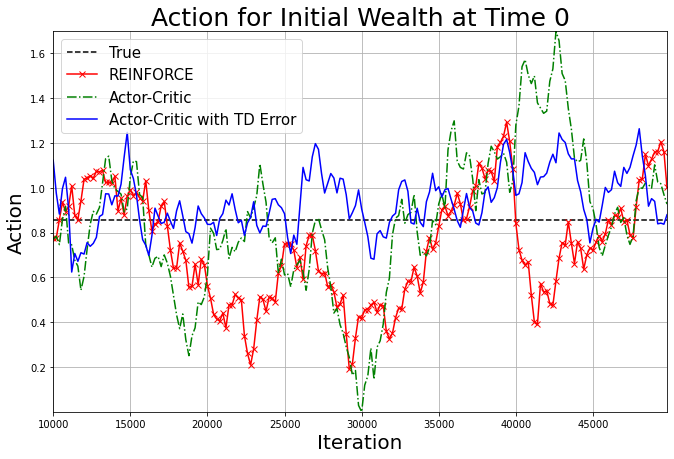

In [ ]:
num_episodes: int = 50000

x: Sequence[int] = range(num_episodes)
y0: Sequence[float] = [base_alloc * (1 + r) ** (1 - steps)] * num_episodes
y1: Sequence[float] = [p(NonTerminal((init_wealth, 0))) for p in
                        itertools.islice(reinforce_policies, num_episodes)]
y2: Sequence[float] = [p(NonTerminal((init_wealth, 0))) for p in
                        itertools.islice(
                            actor_critic_policies,
                            0,
                            num_episodes * steps,
                            steps
                        )]
y3: Sequence[float] = [p(NonTerminal((init_wealth, 0))) for p in
                        itertools.islice(
                            actor_critic_adv_policies,
                            0,
                            num_episodes * steps,
                            steps
                        )]
y4: Sequence[float] = [p(NonTerminal((init_wealth, 0))) for p in
                        itertools.islice(
                            actor_critic_error_policies,
                            0,
                            num_episodes * steps,
                            steps
                        )]

plot_period: int = 200
start: int = 50
x_vals = [[i * plot_period for i in
            range(start, int(num_episodes / plot_period))]] * 4
y_vals = []
for y in [y0, y1, y2, y4]:
    y_vals.append([np.mean(y[i * plot_period:(i + 1) * plot_period])
                    for i in range(start, int(num_episodes / plot_period))])
print(x_vals)
print(y_vals)

plot_list_of_curves(
    x_vals,
    y_vals,
    ["k--", "r-x", "g-.", "b-"],
    ["True", "REINFORCE", "Actor-Critic", "Actor-Critic with TD Error"],
    "Iteration",
    "Action",
    "Action for Initial Wealth at Time 0"
)

In [ ]:
print("Analytical Solution")
print("-------------------")
print()

alloc_list = []
for t in range(steps):
    left: int = steps - t
    growth: float = (1 + r) ** (left - 1)
    alloc: float = base_alloc / growth
    alloc_list.append(alloc)
    print(f"Time {t:d}: Optimal Risky Allocation = {alloc:.3f}")
    print()

Analytical Solution
-------------------

Time 0: Optimal Risky Allocation = 0.855

Time 1: Optimal Risky Allocation = 0.889

Time 2: Optimal Risky Allocation = 0.925

Time 3: Optimal Risky Allocation = 0.962

Time 4: Optimal Risky Allocation = 1.000



In [ ]:
# constant
print("Policy Gradient Solution: Actor Critic TD Error")
print("-----------------------------------------------")
print()
opt_policies: Sequence[FunctionApprox[NonTerminal[AssetAllocState]]] = \
    list(itertools.islice(actor_critic_error_policies, 20000 * steps))
w = init_wealth
wealth_dist_const = []
opt_alloc_dist_const  = []
for t in range(steps):
    opt_alloc: float = np.mean([p(NonTerminal((init_wealth, t)))
                                for p in opt_policies])
    w = opt_alloc * (1 + μ) + (w - opt_alloc) * (1 + r)
    wealth_dist_const.append(w)
    opt_alloc_dist_const.append(opt_alloc)
    print(f"Time {t:d}: Optimal Risky Allocation = {opt_alloc:.3f}")
    print()

Policy Gradient Solution: Actor Critic TD Error
-----------------------------------------------

Time 0: Optimal Risky Allocation = 0.713

Time 1: Optimal Risky Allocation = 0.741

Time 2: Optimal Risky Allocation = 0.771

Time 3: Optimal Risky Allocation = 0.802

Time 4: Optimal Risky Allocation = 0.834

Time 5: Optimal Risky Allocation = 0.867

Time 6: Optimal Risky Allocation = 0.902

Time 7: Optimal Risky Allocation = 0.938

Time 8: Optimal Risky Allocation = 0.976

Time 9: Optimal Risky Allocation = 1.015

Time 10: Optimal Risky Allocation = 1.055

Time 11: Optimal Risky Allocation = 1.097

Time 12: Optimal Risky Allocation = 1.141

Time 13: Optimal Risky Allocation = 1.187

Time 14: Optimal Risky Allocation = 1.234

Time 15: Optimal Risky Allocation = 1.284

Time 16: Optimal Risky Allocation = 1.335

Time 17: Optimal Risky Allocation = 1.388

Time 18: Optimal Risky Allocation = 1.444

Time 19: Optimal Risky Allocation = 1.502

Time 20: Optimal Risky Allocation = 1.562

Time 21: O

In [ ]:
# linear
print("Policy Gradient Solution: Actor Critic TD Error")
print("-----------------------------------------------")
print()
opt_policies: Sequence[FunctionApprox[NonTerminal[AssetAllocState]]] = \
    list(itertools.islice(actor_critic_error_policies, 10000 * steps))
w = init_wealth
wealth_dist_lin = []
opt_alloc_dist_lin  = []
for t in range(steps):
    opt_alloc: float = np.mean([p(NonTerminal((init_wealth, t)))
                                for p in opt_policies])
    w = opt_alloc * (1 + μ) + (w - opt_alloc) * (1 + r)
    wealth_dist_lin.append(w)
    opt_alloc_dist_lin.append(opt_alloc)
    print(f"Time {t:d}: Optimal Risky Allocation = {opt_alloc:.3f}")
    print()

Policy Gradient Solution: Actor Critic TD Error
-----------------------------------------------

Time 0: Optimal Risky Allocation = 0.994

Time 1: Optimal Risky Allocation = 1.033

Time 2: Optimal Risky Allocation = 1.075

Time 3: Optimal Risky Allocation = 1.118

Time 4: Optimal Risky Allocation = 1.162

Time 5: Optimal Risky Allocation = 1.209

Time 6: Optimal Risky Allocation = 1.257

Time 7: Optimal Risky Allocation = 1.308

Time 8: Optimal Risky Allocation = 1.360

Time 9: Optimal Risky Allocation = 1.414

Time 10: Optimal Risky Allocation = 1.471

Time 11: Optimal Risky Allocation = 1.530

Time 12: Optimal Risky Allocation = 1.591

Time 13: Optimal Risky Allocation = 1.655

Time 14: Optimal Risky Allocation = 1.721

Time 15: Optimal Risky Allocation = 1.790

Time 16: Optimal Risky Allocation = 1.861

Time 17: Optimal Risky Allocation = 1.936

Time 18: Optimal Risky Allocation = 2.013

Time 19: Optimal Risky Allocation = 2.093

Time 20: Optimal Risky Allocation = 2.177

Time 21: O

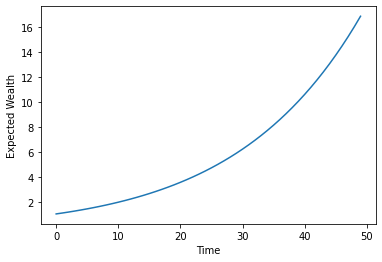

In [ ]:
t = list(range(steps))
import matplotlib.pyplot as plt
plt.plot(t, wealth_dist_const)
plt.xlabel('Time')
plt.ylabel('Expected Wealth')
plt.show()

In [ ]:
plt.plot(t, alloc_list)
plt.plot(t, opt_alloc_dist)
plt.legend(['Analytical solution', 'Actor Critic with TD Error'])
plt.xlabel('Time')
plt.ylabel('Optimal Risky Asset Allocation')
plt.ylim((0, 2))

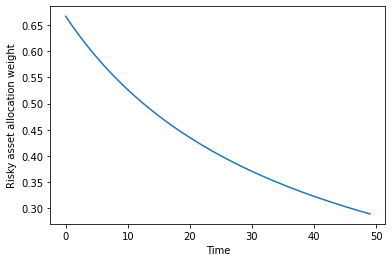

In [ ]:
opt_weights = [opt_alloc_dist_const[i] / wealth_dist_const[i] for i in range(steps)]
plt.plot(list(range(steps)), opt_weights)
plt.xlabel('Time')
plt.ylabel('Risky asset allocation weight')
plt.show()

In [ ]:
# linear step
print("Policy Gradient Solution: Actor Critic TD Error")
print("-----------------------------------------------")
print()
opt_policies: Sequence[FunctionApprox[NonTerminal[AssetAllocState]]] = \
    list(itertools.islice(actor_critic_error_policies, 10000 * steps))
w = init_wealth
wealth_dist_lin_step = []
opt_alloc_dist_lin_step  = []
for t in range(steps):
    opt_alloc: float = np.mean([p(NonTerminal((init_wealth, t)))
                                for p in opt_policies])
    w = opt_alloc * (1 + μ) + (w - opt_alloc) * (1 + r)
    wealth_dist_lin_step.append(w)
    opt_alloc_dist_lin_step.append(opt_alloc)
    print(f"Time {t:d}: Optimal Risky Allocation = {opt_alloc:.3f}")
    print()

Policy Gradient Solution: Actor Critic TD Error
-----------------------------------------------

Time 0: Optimal Risky Allocation = 0.563

Time 1: Optimal Risky Allocation = 0.585

Time 2: Optimal Risky Allocation = 0.609

Time 3: Optimal Risky Allocation = 0.633

Time 4: Optimal Risky Allocation = 0.658

Time 5: Optimal Risky Allocation = 0.685

Time 6: Optimal Risky Allocation = 0.712

Time 7: Optimal Risky Allocation = 0.741

Time 8: Optimal Risky Allocation = 0.770

Time 9: Optimal Risky Allocation = 0.801

Time 10: Optimal Risky Allocation = 0.833

Time 11: Optimal Risky Allocation = 0.866

Time 12: Optimal Risky Allocation = 0.901

Time 13: Optimal Risky Allocation = 0.937

Time 14: Optimal Risky Allocation = 0.975

Time 15: Optimal Risky Allocation = 1.014

Time 16: Optimal Risky Allocation = 1.054

Time 17: Optimal Risky Allocation = 1.096

Time 18: Optimal Risky Allocation = 1.140

Time 19: Optimal Risky Allocation = 1.186

Time 20: Optimal Risky Allocation = 1.233

Time 21: O

In [ ]:
# Quadratic
print("Policy Gradient Solution: Actor Critic TD Error")
print("-----------------------------------------------")
print()
opt_policies: Sequence[FunctionApprox[NonTerminal[AssetAllocState]]] = \
    list(itertools.islice(actor_critic_error_policies, 10000 * steps))
w = init_wealth
wealth_dist_quad = []
opt_alloc_dist_quad  = []
for t in range(steps):
    opt_alloc: float = np.mean([p(NonTerminal((init_wealth, t)))
                                for p in opt_policies])
    w = opt_alloc * (1 + μ) + (w - opt_alloc) * (1 + r)
    wealth_dist_quad.append(w)
    opt_alloc_dist_quad.append(opt_alloc)
    print(f"Time {t:d}: Optimal Risky Allocation = {opt_alloc:.3f}")
    print()

Policy Gradient Solution: Actor Critic TD Error
-----------------------------------------------

Time 0: Optimal Risky Allocation = 0.795

Time 1: Optimal Risky Allocation = 0.827

Time 2: Optimal Risky Allocation = 0.860

Time 3: Optimal Risky Allocation = 0.895

Time 4: Optimal Risky Allocation = 0.931

Time 5: Optimal Risky Allocation = 0.968

Time 6: Optimal Risky Allocation = 1.007

Time 7: Optimal Risky Allocation = 1.047

Time 8: Optimal Risky Allocation = 1.089

Time 9: Optimal Risky Allocation = 1.132

Time 10: Optimal Risky Allocation = 1.177

Time 11: Optimal Risky Allocation = 1.225

Time 12: Optimal Risky Allocation = 1.274

Time 13: Optimal Risky Allocation = 1.325

Time 14: Optimal Risky Allocation = 1.377

Time 15: Optimal Risky Allocation = 1.433

Time 16: Optimal Risky Allocation = 1.490

Time 17: Optimal Risky Allocation = 1.549

Time 18: Optimal Risky Allocation = 1.611

Time 19: Optimal Risky Allocation = 1.676

Time 20: Optimal Risky Allocation = 1.743

Time 21: O

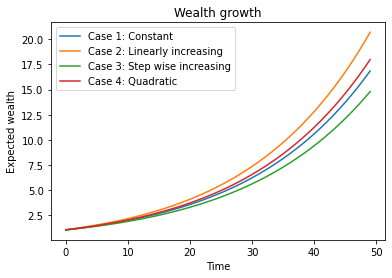

In [ ]:
t = list(range(50))
plt.plot(t, wealth_dist_const)
plt.plot(t, wealth_dist_lin)
plt.plot(t, wealth_dist_lin_step)
plt.plot(t, wealth_dist_quad)
plt.legend(['Case 1: Constant', 'Case 2: Linearly increasing', 'Case 3: Step wise increasing', 'Case 4: Quadratic'])
plt.title('Wealth growth')
plt.xlabel('Time')
plt.ylabel('Expected wealth')
plt.show()

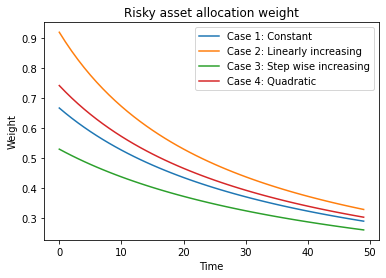

In [ ]:
t = list(range(50))
opt_weights_const = [opt_alloc_dist_const[i] / wealth_dist_const[i] for i in range(steps)]
opt_weights_lin = [opt_alloc_dist_lin[i] / wealth_dist_lin[i] for i in range(steps)]
opt_weights_lin_step = [opt_alloc_dist_lin_step[i] / wealth_dist_lin_step[i] for i in range(steps)]
opt_weights_quad = [opt_alloc_dist_quad[i] / wealth_dist_quad[i] for i in range(steps)]
plt.plot(t, opt_weights_const)
plt.plot(t, opt_weights_lin)
plt.plot(t, opt_weights_lin_step)
plt.plot(t, opt_weights_quad)
plt.legend(['Case 1: Constant', 'Case 2: Linearly increasing', 'Case 3: Step wise increasing', 'Case 4: Quadratic'])
plt.title('Risky asset allocation weight')
plt.xlabel('Time')
plt.ylabel('Weight')
plt.show()

In [ ]:
# riskfree rate historical data
# Const
print("Policy Gradient Solution: Actor Critic TD Error")
print("-----------------------------------------------")
print()
opt_policies: Sequence[FunctionApprox[NonTerminal[AssetAllocState]]] = \
    list(itertools.islice(actor_critic_error_policies, 10000 * steps))
w = init_wealth
wealth_dist_riskfree_const = []
opt_alloc_dist_riskfree_const  = []
for t in range(steps):
    opt_alloc: float = np.mean([p(NonTerminal((init_wealth, t)))
                                for p in opt_policies])
    w = opt_alloc * (1 + μ) + (w - opt_alloc) * (1 + r)
    wealth_dist_riskfree_const.append(w)
    opt_alloc_dist_riskfree_const.append(opt_alloc)
    print(f"Time {t:d}: Optimal Risky Allocation = {opt_alloc:.3f}")
    print()

Policy Gradient Solution: Actor Critic TD Error
-----------------------------------------------

Time 0: Optimal Risky Allocation = 1.418

Time 1: Optimal Risky Allocation = 1.475

Time 2: Optimal Risky Allocation = 1.534

Time 3: Optimal Risky Allocation = 1.595

Time 4: Optimal Risky Allocation = 1.659

Time 5: Optimal Risky Allocation = 1.725

Time 6: Optimal Risky Allocation = 1.794

Time 7: Optimal Risky Allocation = 1.866

Time 8: Optimal Risky Allocation = 1.941

Time 9: Optimal Risky Allocation = 2.018

Time 10: Optimal Risky Allocation = 2.099

Time 11: Optimal Risky Allocation = 2.183

Time 12: Optimal Risky Allocation = 2.270

Time 13: Optimal Risky Allocation = 2.361

Time 14: Optimal Risky Allocation = 2.455

Time 15: Optimal Risky Allocation = 2.554

Time 16: Optimal Risky Allocation = 2.656

Time 17: Optimal Risky Allocation = 2.762

Time 18: Optimal Risky Allocation = 2.872

Time 19: Optimal Risky Allocation = 2.987

Time 20: Optimal Risky Allocation = 3.107

Time 21: O

In [ ]:
# riskfree rate historical data
# historical
print("Policy Gradient Solution: Actor Critic TD Error")
print("-----------------------------------------------")
print()
opt_policies: Sequence[FunctionApprox[NonTerminal[AssetAllocState]]] = \
    list(itertools.islice(actor_critic_error_policies, 10000 * steps))
w = init_wealth
wealth_dist_riskfree_hist = []
opt_alloc_dist_riskfree_hist  = []
for t in range(steps):
    opt_alloc: float = np.mean([p(NonTerminal((init_wealth, t)))
                                for p in opt_policies])
    w = opt_alloc * (1 + μ) + (w - opt_alloc) * (1 + r)
    wealth_dist_riskfree_hist.append(w)
    opt_alloc_dist_riskfree_hist.append(opt_alloc)
    print(f"Time {t:d}: Optimal Risky Allocation = {opt_alloc:.3f}")
    print()

Policy Gradient Solution: Actor Critic TD Error
-----------------------------------------------

Time 0: Optimal Risky Allocation = 0.978

Time 1: Optimal Risky Allocation = 1.017

Time 2: Optimal Risky Allocation = 1.058

Time 3: Optimal Risky Allocation = 1.100

Time 4: Optimal Risky Allocation = 1.144

Time 5: Optimal Risky Allocation = 1.190

Time 6: Optimal Risky Allocation = 1.237

Time 7: Optimal Risky Allocation = 1.287

Time 8: Optimal Risky Allocation = 1.338

Time 9: Optimal Risky Allocation = 1.392

Time 10: Optimal Risky Allocation = 1.448

Time 11: Optimal Risky Allocation = 1.505

Time 12: Optimal Risky Allocation = 1.566

Time 13: Optimal Risky Allocation = 1.628

Time 14: Optimal Risky Allocation = 1.693

Time 15: Optimal Risky Allocation = 1.761

Time 16: Optimal Risky Allocation = 1.832

Time 17: Optimal Risky Allocation = 1.905

Time 18: Optimal Risky Allocation = 1.981

Time 19: Optimal Risky Allocation = 2.060

Time 20: Optimal Risky Allocation = 2.143

Time 21: O

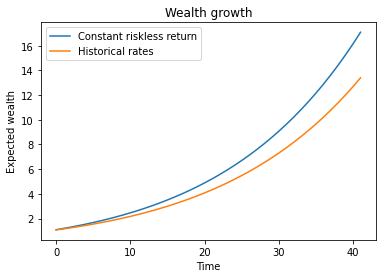

In [ ]:
t = list(range(42))
plt.plot(t, wealth_dist_riskfree_const)
plt.plot(t, wealth_dist_riskfree_hist)
plt.legend(['Constant riskless return', 'Historical rates'])
plt.title('Wealth growth')
plt.xlabel('Time')
plt.ylabel('Expected wealth')
plt.show()

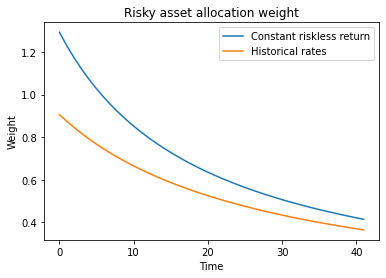

In [ ]:
t = list(range(42))
opt_weights_riskfree_const = [opt_alloc_dist_riskfree_const[i] / wealth_dist_riskfree_const[i] for i in range(steps)]
opt_weights_riskfree_hist = [opt_alloc_dist_riskfree_hist[i] / wealth_dist_riskfree_hist[i] for i in range(steps)]
plt.plot(t, opt_weights_riskfree_const)
plt.plot(t, opt_weights_riskfree_hist)
plt.legend(['Constant riskless return', 'Historical rates'])
plt.title('Risky asset allocation weight')
plt.xlabel('Time')
plt.ylabel('Weight')
plt.show()